We're gonna stress-test the strip methods.

In [73]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy import ndimage
from scipy import signal
from scipy.stats import linregress
from scipy.signal import convolve2d, gaussian, argrelextrema
from scipy.interpolate import interp1d
from sklearn.preprocessing import normalize
from skimage.transform import rotate
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle as cPickle
import librosa
import glob
import re
import sys
import os
import mido
from mido import MidiFile
import cv2
import PIL
from PIL import Image

In [2]:
def importImage(pngfile):
    img = ndimage.imread(pngfile, flatten=True)
    img = 1 - img/255.0 # make white -> 0, black -> 1
    return img

In [3]:
def showImage(X, sz = (12,12)):
    plt.figure(figsize=sz)
    plt.imshow(1-X, cmap='gray')

In [4]:
def rotateToHorizontal(img, lb=-.5, ub=.5, incr=.02, topN=40):
    bestscore = -np.inf
    bestTheta = 0
    for theta in np.arange(lb, ub, incr):
        imgRot = rotate(img,theta)
        rsums = np.sum(imgRot, axis=1)
        rsums_sorted = sorted(rsums)[::-1]
        curscore = np.sum(rsums_sorted[0:topN])
        if curscore > bestscore:
            bestscore = curscore
            bestTheta = theta
    result = rotate(img,bestTheta)
    return result, bestTheta

In [5]:
def getBoundingBox(img, thresh=.01, buff=0.05):
    r = img.shape[0]
    c = img.shape[1]
    
    cmeans = np.mean(img, axis=0)
    cmean_thresh = np.max(cmeans) * thresh
    cidxs_above = np.argwhere(cmeans > cmean_thresh)
    col_start = cidxs_above[0][0]
    col_end = cidxs_above[-1][0]
    
    rmeans = np.mean(img, axis=1)
    rmean_thresh = np.max(rmeans) * thresh
    ridxs_above = np.argwhere(rmeans > rmean_thresh)
    row_start = ridxs_above[0][0]
    row_end = ridxs_above[-1][0]
    
    # add buffer to ignore clefs
    bufflen = np.int((col_end - col_start) * buff)
    col_start_adj = col_start + bufflen
    
    return (row_start, col_start_adj), col_end - col_start_adj, row_end - row_start

In [6]:
def showImageWithBB(X, loc, w, h, sz=(12,12)):
    fig = plt.figure(figsize=sz)
    plt.imshow(1-X, cmap='gray')
    ax = fig.gca()
    rect = patches.Rectangle((loc[1],loc[0]), w, h, linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()

In [7]:
def getCropped(X, thresh=0.01):
    ll, w, h = getBoundingBox(X, thresh=thresh)
    return X[ll[0]:ll[0]+h,ll[1]:ll[1]+w]

In [64]:
def getStripBoundaries(X, showPlot = False, debug=False):
    # find staves
    filt = np.vstack((np.ones(21),np.zeros(21),-1*np.ones(21))) # emphasize horizontal lines
    Xfilt = signal.convolve2d(X-np.mean(X), filt, mode='same')
    rsum = np.sum(Xfilt, axis=1)
    rsum_spectra = librosa.core.stft(rsum,n_fft=32,hop_length=1) # look for high frequency oscillations
    spectra_max = np.max(rsum_spectra[4:10,:], axis=0)
    spectra_max_smoothed = np.convolve(spectra_max,np.hanning(15),'same')
    peakidxs = signal.find_peaks_cwt(spectra_max_smoothed, range(15,41,1))
    #assert(len(peakidxs) % 2 == 0)
    
    if debug:
        print("X filter:")
        plt.imshow(Xfilt)
        print("rsum is: " +  str(rsum))
        print("rsum spectra: " + str(rsum_spectra))
        print("spectra max: " + str(spectra_max))
        print("num peak ids: " + str(len(peakidxs)))
    
    # determine boundaries
    numStrips = np.int(len(peakidxs))
    boundaries = []
    for i in range(numStrips):
        peak1idx = peakidxs[i]
        if i >= (numStrips - 1):
            break
        peak2idx = peakidxs[i+1]
        midpt = np.int((peak1idx + peak2idx)/2.0)
        boundaries.append(midpt)
    boundaries.insert(0, 0)  # for first strip
    boundaries.append(X.shape[0]-1) # for last strip
    # we might skip some
    if debug:
        print("num boundaries: " + str(len(boundaries)))
    
    # show peak picking results (for debugging)
    if showPlot:
        plt.plot(spectra_max_smoothed)
        for pk in peakidxs:
            plt.axvline(x=pk, color='r', linewidth=1)
            
    return boundaries

In [9]:
def visualizeBoundaries(X, bnds, savefile = None):
    showImage(X)
    for bnd in bnds:
        plt.axhline(y=bnd, color='r', linewidth=1)
    if savefile:
        plt.savefig(savefile)

In [58]:
def getStrips(X, bnds, debug=False):
    strips = []
    print("num bounds: " + str(len(bnds)))
    for i in range(len(bnds)-1):
        rstart = bnds[i]
        rend = bnds[i+1] + 1 # include endpoint
        chunk = X[rstart:rend,:]
        strips.append(chunk)
    return strips

In [11]:
def showStrips(strips):
    for strip in strips:
        showImage(strip)

In [12]:
def locateStaffLines(s, delta = 3, debug=False):
    medvals = np.median(s, axis=1)
    if debug:
        print("num medvals: " + str(len(medvals)))
        print("medvals are: " +  str(medvals))
    for i, curVal in enumerate(medvals):
        if i > delta and i < len(medvals)-delta:
            if curVal != np.max(medvals[i-delta:i+delta+1]): # only keep local maxima
                medvals[i] = 0
    idxs_sorted_val = np.argsort(medvals)[::-1]
    idxs_lines = sorted(idxs_sorted_val[0:10]) # going to change from [0:10] to [0:10] skipping by 2
    idxs_lines = idxs_lines[1::2] # we want just 5, so start at the second and skip every other.
    if debug:
        print("sorted idxs val before clip: " + str(idxs_sorted_val))
        print("num sorted idxs: " + str(len(idxs_sorted_val)))
        print("idxs_lines number after clip: " + str(len(idxs_lines)))
        print("idxs_lines: " + str(idxs_lines))
    return np.array(idxs_lines)

In [13]:
def estimateMidiNum2PixelRowMapping(s, lineIdxs):
    x = np.array([4, 2, 0, -2, -4]) # midi nums for staff lines, reformatted to be 0 in the middle, etc.
    m, b, _, _, _ = linregress(x, lineIdxs)
    return (m,b)

In [14]:
def estimatePixelRow (midinum, m, b):
    return np.int(np.round(midinum * m + b))

In [15]:
def estimatePixelRow2MidiNumMapping(s, lineIdxs):
    x = np.array([4, 2, 0, -2, -4]) # midi nums for staff lines
    m, b, _, _, _ = linregress(lineIdxs, x)
    return (m,b)

In [59]:
def getStripBoundariesNonPiano(X, showPlot = False, debug = False):
    # find staves
    filt = np.vstack((np.ones(21),np.zeros(21),-1*np.ones(21))) # emphasize horizontal lines
    Xfilt = signal.convolve2d(X-np.mean(X), filt, mode='same')
    rsum = np.sum(Xfilt, axis=1)
    rsum_spectra = librosa.core.stft(rsum,n_fft=32,hop_length=1) # look for high frequency oscillations
    spectra_max = np.max(rsum_spectra[4:10,:], axis=0)
    spectra_max_smoothed = np.convolve(spectra_max,np.hanning(15),'same')
    peakidxs = signal.find_peaks_cwt(spectra_max_smoothed, range(15,41,1))
    #assert(len(peakidxs) % 2 == 0)
    if debug:
        print("X filter:")
        plt.imshow(Xfilt)
        print("rsum is: " +  str(rsum))
        print("rsum spectra: " + str(rsum_spectra))
        print("spectra max: " + str(spectra_max))
        print("num peak ids: " + str(len(peakidxs)))
        print("peak ids: " + str(peakidxs))
    
    # determine boundaries
    numStrips = np.int(len(peakidxs)/2) # note the lack of -1 here
    boundaries = []
    for i in range(numStrips):
        peak1idx = peakidxs[2*i]
        peak2idx = peakidxs[2*i+1]
        midpt = np.int((peak1idx + peak2idx)/2.0)
        boundaries.append(midpt)
    boundaries.insert(0, 0)  # for first strip
    boundaries.append(X.shape[0]-1) # for last strip
    
    # show peak picking results (for debugging)
    if showPlot:
        plt.plot(spectra_max_smoothed)
        for pk in peakidxs:
            plt.axvline(x=pk, color='r', linewidth=1)
            
    return boundaries

In [17]:
pics = os.listdir('pdf/mini_dataset_png')

In [18]:
pic_names = []
for pic in pics:
    name = os.path.join('pdf/mini_dataset_png', pic)
    pic_names.append(name)

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  from ipykernel import kernelapp as app


showing bounding box image...


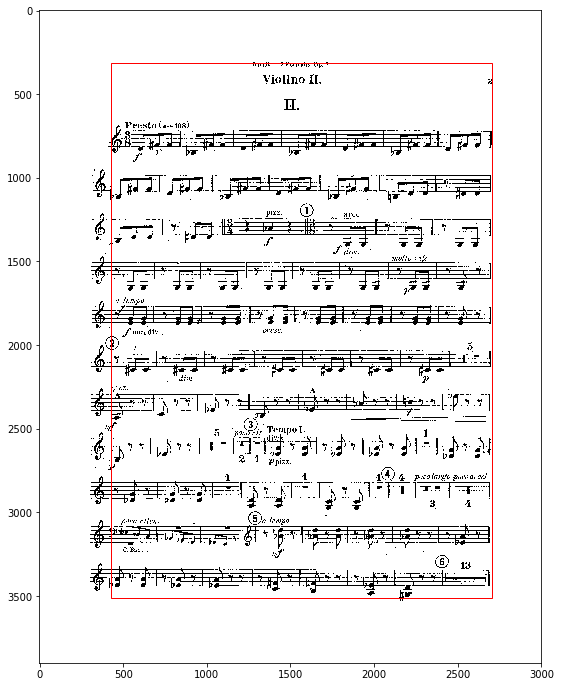

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')


X filter:
rsum is: [ 15906.07569639  23520.          19832.         ...  -6941.
 -12639.         -23607.07569639]
rsum spectra: [[-12631.58   +0.0000000e+00j -12687.675  +0.0000000e+00j
  -12833.63   +0.0000000e+00j ...  32381.066  +0.0000000e+00j
   32381.195  +0.0000000e+00j  32381.066  +0.0000000e+00j]
 [-33022.668  -4.5474735e-13j -30083.225  -1.5065120e+04j
  -21686.223  -2.7897598e+04j ...   2379.4448 -7.6919907e+03j
    3909.609  -1.0231815e-12j   2379.4448 +7.6919907e+03j]
 [122101.734  +5.1448789e-12j 108742.586  +5.4212422e+04j
   72112.445  +9.5602867e+04j ... -66619.35   +3.5081250e+04j
  -75654.38   -2.5724394e-12j -66619.35   -3.5081250e+04j]
 ...
 [  -544.1182 -5.1448789e-12j    507.22778-1.4121497e+02j
    -431.5478 +2.4408081e+02j ...  13142.269  +5.4701299e+03j
  -14355.997  +2.5724394e-12j  13142.269  -5.4701299e+03j]
 [  2451.1917 -4.0927262e-12j  -2445.2622 +1.7194127e+02j
    2405.4326 -3.4581155e+02j ... -12417.45   -2.7460547e+03j
   12842.963  -1.0231815e-12j -

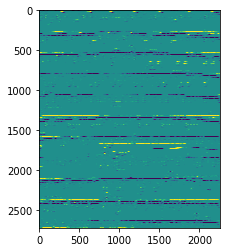

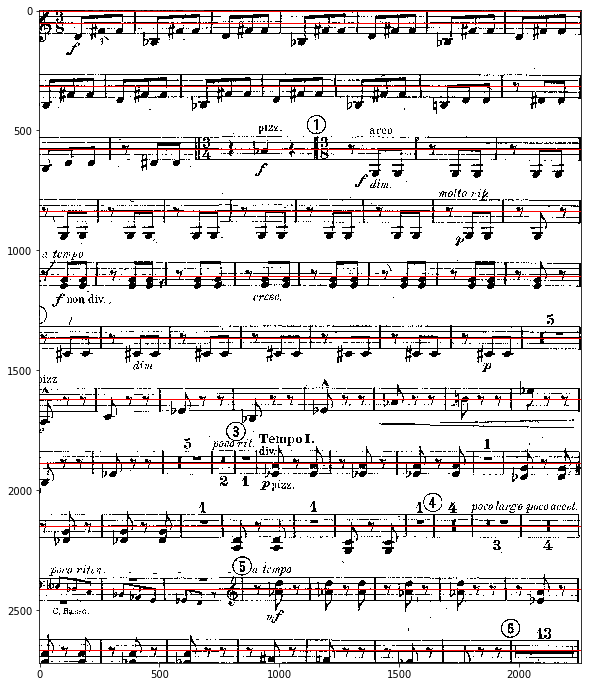

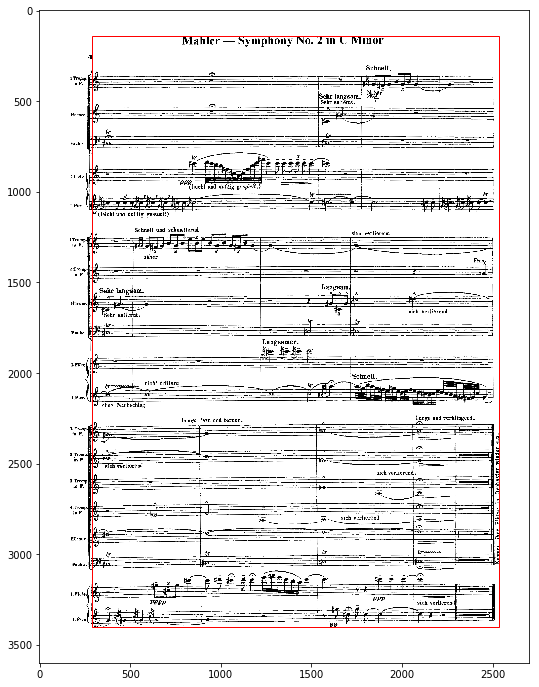

X filter:
rsum is: [ 3285.13127493   288.93727783  -322.08895885 ... -1684.90056352
   253.64131325 -1833.76712586]
rsum spectra: [[  2128.584 +0.0000000e+00j   2122.0332+0.0000000e+00j
    2089.6084+0.0000000e+00j ... -12148.772 +0.0000000e+00j
  -12382.829 +0.0000000e+00j -12148.772 +0.0000000e+00j]
 [ -2023.3381+2.1316282e-14j  -1956.76  -3.6828906e+02j
   -1779.1898-6.9062012e+02j ...  21236.926 -6.1826304e+03j
   22228.084 +1.1368684e-12j  21236.926 +6.1826304e+03j]
 [  3388.9624-5.6843419e-14j   2989.0178+1.5486870e+03j
    1888.7906+2.6918684e+03j ... -23627.172 +8.3166201e+03j
  -25111.58  -1.5526046e-12j -23627.172 -8.3166201e+03j]
 ...
 [  2482.3452-5.6843419e-14j  -2249.7344+9.6068658e+02j
    1628.9198-1.6957244e+03j ...   1851.6279+7.1383704e+02j
   -1991.8279-2.6638484e-13j   1851.6279-7.1383704e+02j]
 [ -2443.7195-6.3948846e-14j   2387.3896-4.5542038e+02j
   -2210.3784+8.7779358e+02j ...  -2218.1782-4.3176318e+02j
    2291.0024-6.8212103e-13j  -2218.1782+4.3176318e+02j]


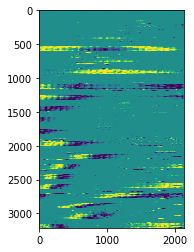

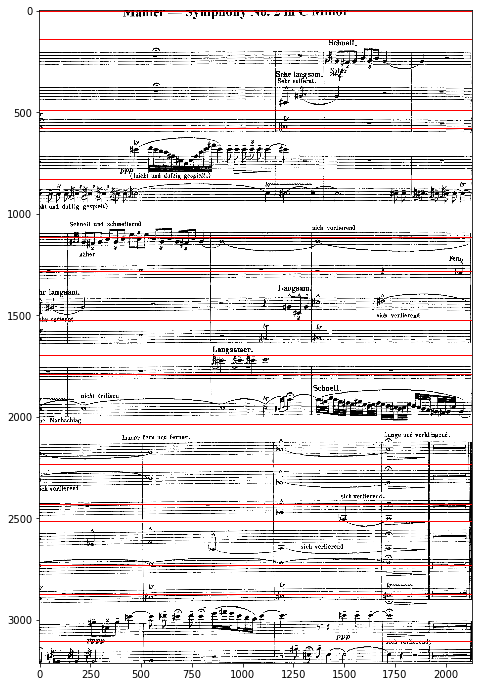

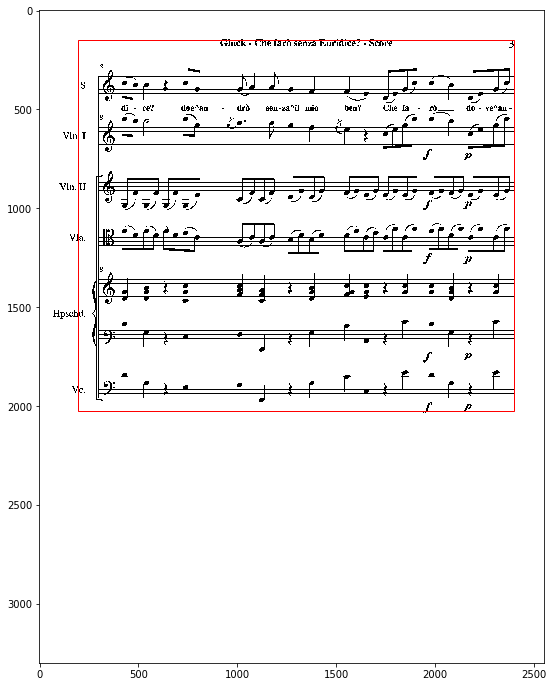

X filter:
rsum is: [ 5.02755570e+03 -5.62000000e+02 -9.61000000e+02 ... -2.54268828e-13
  4.14219216e+04  3.78929920e+03]
rsum spectra: [[ 1.5097342e+01+0.00000000e+00j -1.6084681e+01+0.00000000e+00j
  -9.7883553e+01+0.00000000e+00j ...  8.4688695e+04+0.00000000e+00j
   8.5518969e+04+0.00000000e+00j  8.4688695e+04+0.00000000e+00j]
 [-1.0611604e+03+2.41584530e-13j -1.0115419e+03-4.09283081e+02j
  -8.5634515e+02-7.90230835e+02j ... -8.2075234e+04+1.61097910e+04j
  -8.4433125e+04-3.62021524e-12j -8.2075234e+04-1.61097910e+04j]
 [ 1.8856982e+03+2.74464316e-13j  1.7338207e+03+6.71393860e+02j
   1.3276552e+03+1.20205750e+03j ...  7.3211617e+04-2.95572129e+04j
   7.9710156e+04+1.00485916e-14j  7.3211617e+04+2.95572129e+04j]
 ...
 [ 5.1321812e+03-4.70906307e-14j -4.7288809e+03+1.88887280e+03j
   3.5955801e+03-3.42215723e+03j ...  6.6119750e+04+2.67353848e+04j
  -7.2002977e+04-1.00485916e-14j  6.6119750e+04-2.67353848e+04j]
 [-5.3891465e+03+9.94759830e-14j  5.2271030e+03-1.05446033e+03j
  -4.77

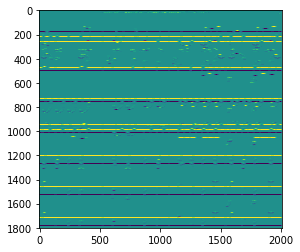

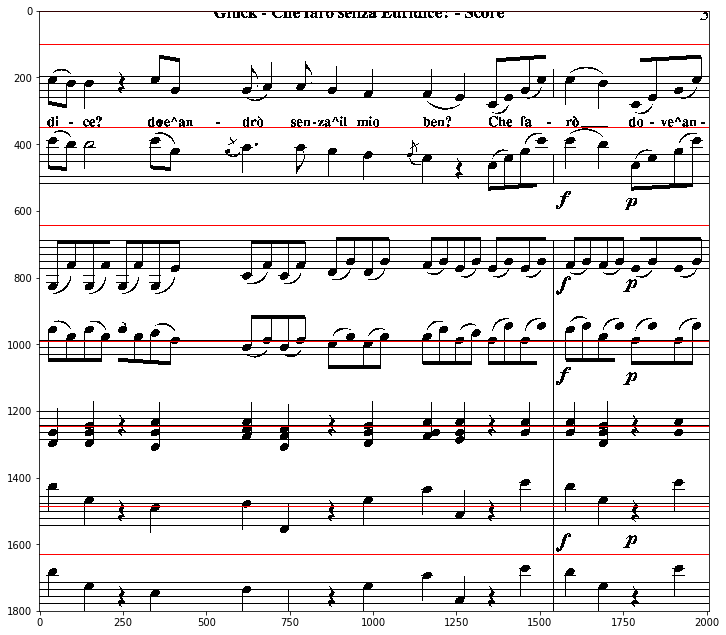

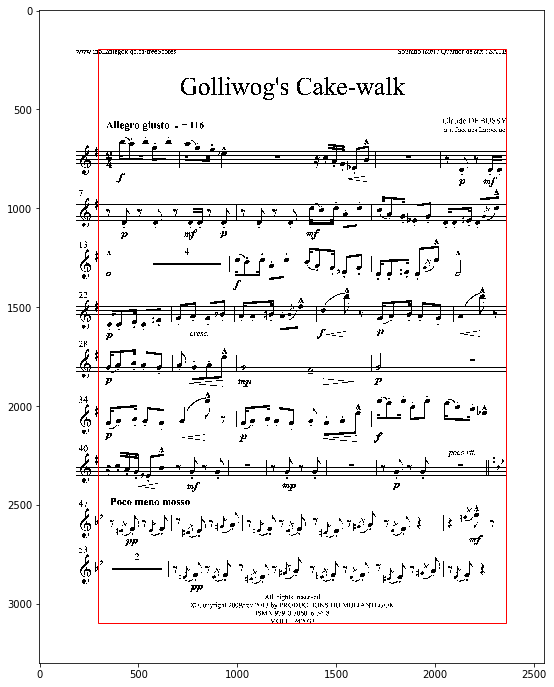

X filter:
rsum is: [ 4487.05285464 -1808.         -1912.         ...   651.
  2604.         -2653.05285464]
rsum spectra: [[-4857.9214 +0.0000000e+00j -4878.338  +0.0000000e+00j
  -4912.8535 +0.0000000e+00j ...  1843.8983 +0.0000000e+00j
   1816.1166 +0.0000000e+00j  1843.8983 +0.0000000e+00j]
 [ 5864.8867 +2.2737368e-13j  5583.3184 +1.3108890e+03j
   4809.253  +2.4036770e+03j ... -2896.3325 +8.2943671e+02j
  -3089.6438 -1.4210855e-14j -2896.3325 -8.2943671e+02j]
 [ -800.34106+3.2155493e-13j -1319.3491 +7.3559381e+02j
  -2568.8848 +7.0294989e+02j ...  3767.9949 -1.4874307e+03j
   4015.9346 +3.8815115e-13j  3767.9949 +1.4874307e+03j]
 ...
 [ 6497.715  -3.2155493e-13j -5916.3037 +2.5904460e+03j
   4278.1255 -4.6505488e+03j ...  5607.518  +2.2546980e+03j
  -6088.929  +6.6596210e-14j  5607.518  -2.2546980e+03j]
 [-6112.798  +2.2737368e-13j  5917.883  -1.1219852e+03j
  -5385.1064 +2.1102505e+03j ... -6147.1426 -1.2367626e+03j
   6340.528  +1.4210855e-14j -6147.1426 +1.2367626e+03j]
 [ 6390.

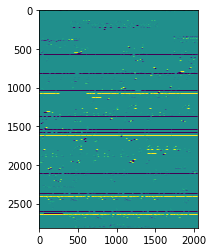

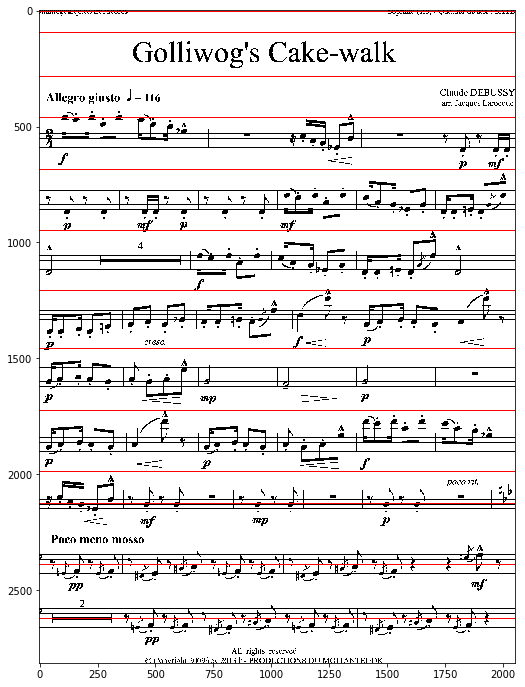

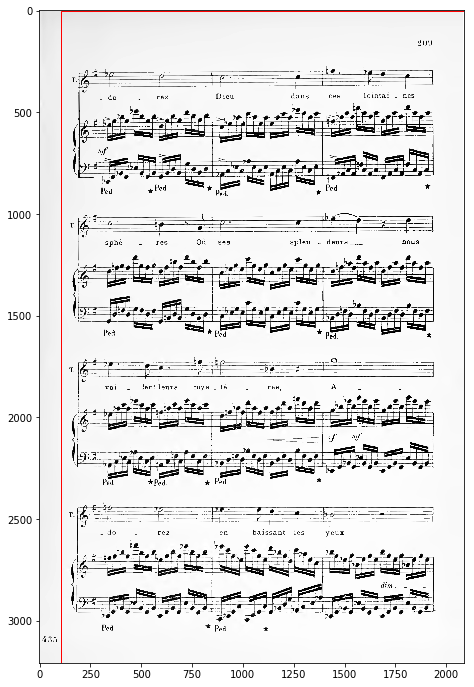

X filter:
rsum is: [  2256.6812849     597.08613005  -1259.22915095 ...   9314.53829436
 -10772.91670987 -20224.58722609]
rsum spectra: [[ -6751.7437 +0.0000000e+00j  -6557.416  +0.0000000e+00j
   -5984.0737 +0.0000000e+00j ...  30505.465  +0.0000000e+00j
   30747.361  +0.0000000e+00j  30505.465  +0.0000000e+00j]
 [  7184.785  -6.8212103e-13j   7085.4424 +1.4955194e+03j
    6778.291  +2.9874905e+03j ... -17263.553  +7.3173077e+02j
  -17162.467  -2.2737368e-12j -17263.553  -7.3173077e+02j]
 [  3685.176  -6.6596210e-14j   2539.6846 +3.4387617e+03j
    -518.79114+5.5995254e+03j ... -13639.969  +9.8965967e+03j
  -16533.484  +4.5474735e-13j -13639.969  -9.8965967e+03j]
 ...
 [   955.7147 -3.8815115e-13j   -798.94226+5.3461584e+02j
     380.37286-9.0121960e+02j ...   -140.37419-1.4953415e+02j
     203.52972+4.5474735e-13j   -140.37419+1.4953415e+02j]
 [  -496.10342+1.8189894e-12j    491.0126 +2.7744293e+00j
    -475.01413-1.1945445e+01j ...   -261.29575-4.2247192e+01j
     278.1626 +4.547473

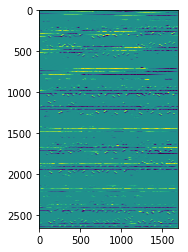

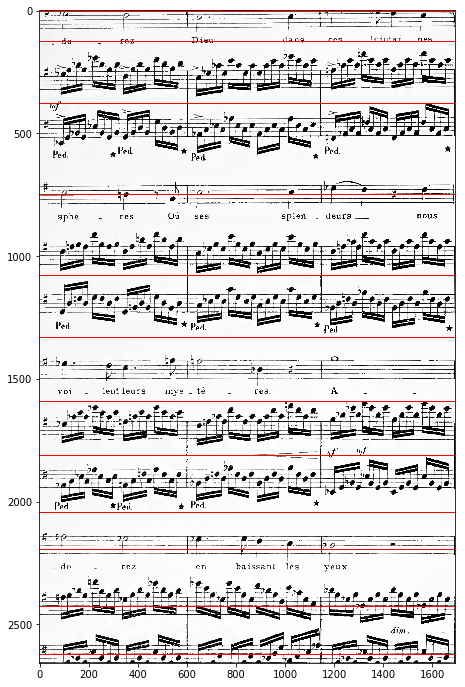

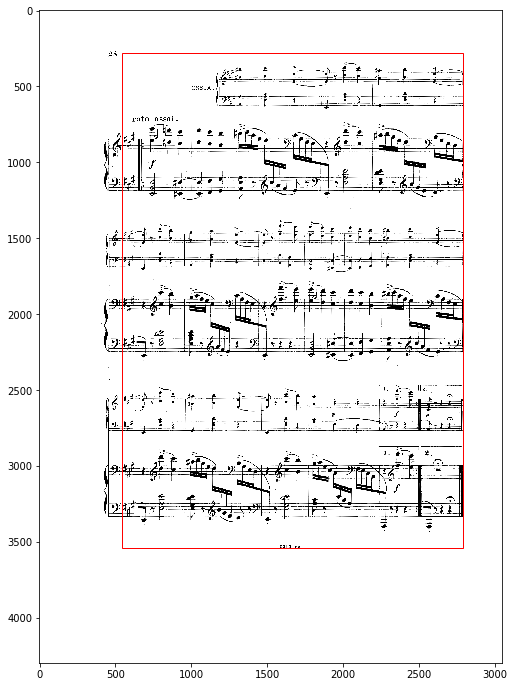

X filter:
rsum is: [ 25245.98100108  -1231.77818199 -26676.9582692  ...  33292.8192498
  14545.79613174 -33267.59871011]
rsum spectra: [[-53948.     +0.00000000e+00j -52764.74   +0.00000000e+00j
  -49632.914  +0.00000000e+00j ...  96101.79   +0.00000000e+00j
   96980.06   +0.00000000e+00j  96101.79   +0.00000000e+00j]
 [ 52497.66   +1.93267624e-12j  51715.312  +9.99832520e+03j
   48987.375  +1.97691406e+04j ... -82855.77   +1.40492979e+04j
  -84754.875  -5.68434189e-12j -82855.77   -1.40492979e+04j]
 [-22374.832  +3.48193414e-12j -22228.084  -3.15256860e+03j
  -22152.941  -6.43391504e+03j ...  48075.36   -1.53111318e+04j
   50734.645  -3.63797881e-12j  48075.36   +1.53111318e+04j]
 ...
 [  2280.9666 -1.66294474e-12j  -1804.4926 +1.02100183e+03j
     981.46857-1.48098608e+03j ...  24700.244  +1.02655703e+04j
  -27014.426  -3.63797881e-12j  24700.244  -1.02655703e+04j]
 [ -1546.7126 -1.93267624e-12j   1703.6158 -2.27237778e+02j
   -1762.5554 +5.76266296e+02j ... -26338.508  -5.18908691e+

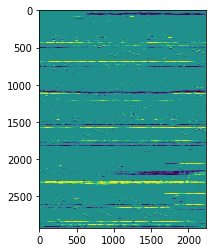

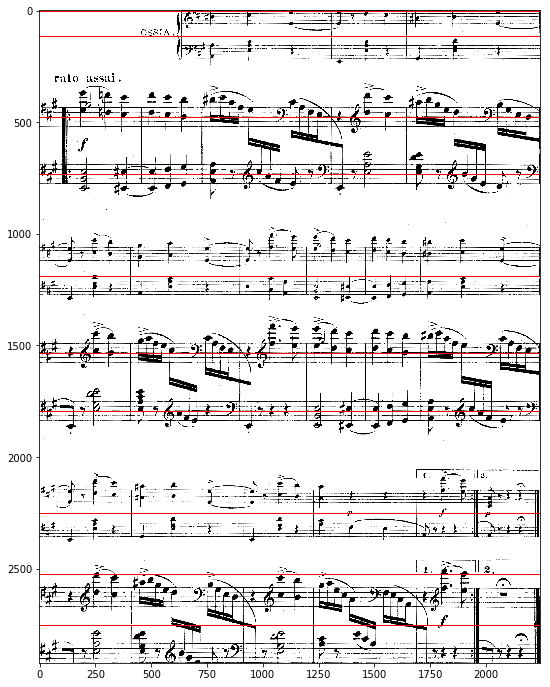

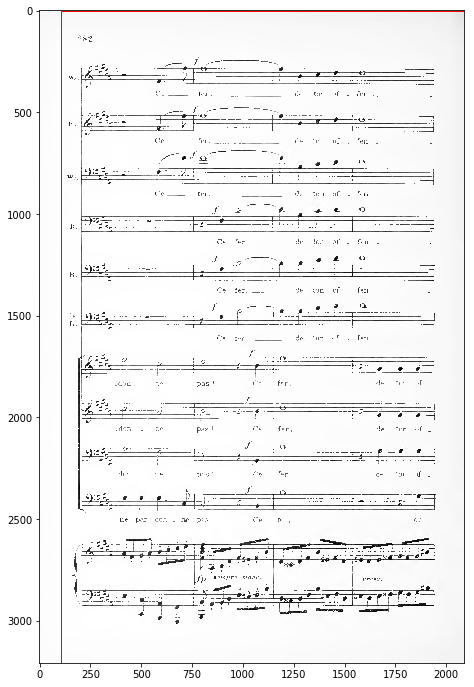

X filter:
rsum is: [ 4682.69625672     9.71629983  4923.0979169  ... -1170.67842543
  -271.99743658 -3457.39417084]
rsum spectra: [[ -2017.9973+0.0000000e+00j  -2136.2085+0.0000000e+00j
   -2445.5286+0.0000000e+00j ...  -2657.2354+0.0000000e+00j
   -2814.5178+0.0000000e+00j  -2657.2354+0.0000000e+00j]
 [-14907.473 -5.4711791e-12j -13811.843 -6.1140317e+03j
  -10638.313 -1.1425902e+04j ...   8558.887 -2.9290886e+03j
    8981.154 +1.1368684e-13j   8558.887 +2.9290886e+03j]
 [ 38426.285 +3.7672505e-13j  34782.754 +1.5799767e+04j
   24738.98  +2.8285205e+04j ... -10825.617 +3.7161763e+03j
  -11511.09  -3.2155493e-13j -10825.617 -3.7161763e+03j]
 ...
 [  5443.9414-2.1957145e-12j  -4926.6167+2.2089597e+03j
    3464.442 -3.9178157e+03j ...   3235.3782+1.2838983e+03j
   -3506.5178+3.2155493e-13j   3235.3782-1.2838983e+03j]
 [ -3637.4617+1.4210855e-14j   3491.683 -8.9534595e+02j
   -3112.921 +1.6989636e+03j ...  -3465.0466-7.2799152e+02j
    3578.0325-1.1368684e-13j  -3465.0466+7.2799152e+02j]


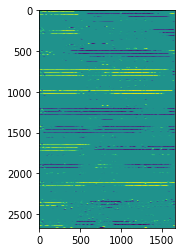

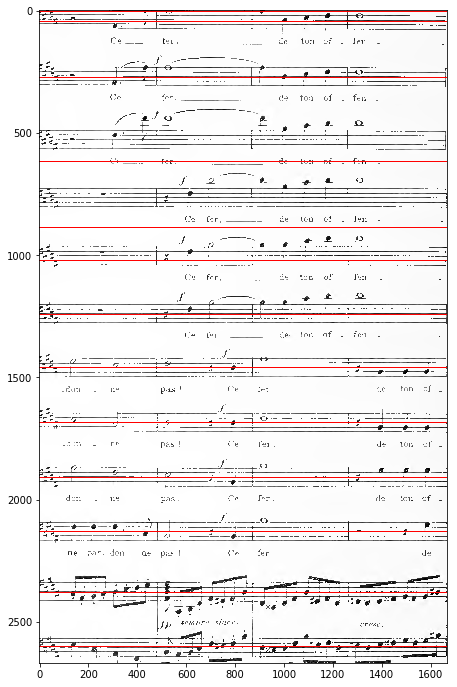

In [21]:
for pic in pic_names[0:7]:
    I = importImage(pic)
    Irot, theta = rotateToHorizontal(I)
    ll, bbw, bbh = getBoundingBox(Irot)
    print("showing bounding box image...")
    showImageWithBB(Irot, ll, bbw, bbh)
    Icrop = getCropped(Irot, thresh=0.2)
    bnds = getStripBoundariesNonPiano(Icrop, debug=True)
    print("visualizing boundaries...")
    visualizeBoundaries(Icrop, bnds)

Maybe we can do some manual corrections?

In [22]:
def inspectBoundariesPre(filelist, outdir):
    os.mkdir(outdir)
    predfile = outdir + '/bnds.predicted.txt' # text file with boundary predictions
    f = open(predfile,'w')
    for i, curfile in enumerate(filelist):
        
        # get strip boundaries
        I = importImage(curfile)
        Irot, theta = rotateToHorizontal(I)
        ll, w, h = getBoundingBox(Irot)
        Icrop = getCropped(Irot)
        bnds = getStripBoundaries(Icrop)
        
        # generate images for inspection
        basename = os.path.splitext(os.path.basename(curfile))[0]
        outfile = '%s/%s.png' % (outdir,basename)
        visualizeBoundaries(Icrop, bnds, outfile)
        
        # write to text file
        strOut = '%s %s\n' % (basename, ' '.join(map(str,bnds)))
        f.write(strOut)
        
    f.close()

In [26]:
visualize_dir_pre = 'vis_bnds_test'

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  from ipykernel import kernelapp as app
/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')


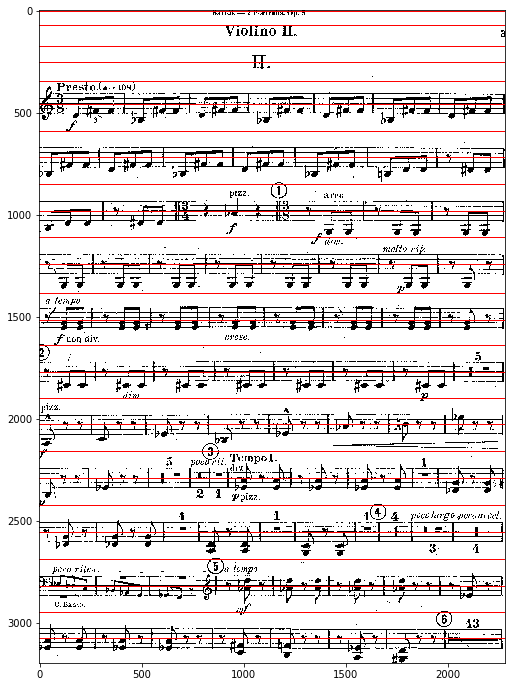

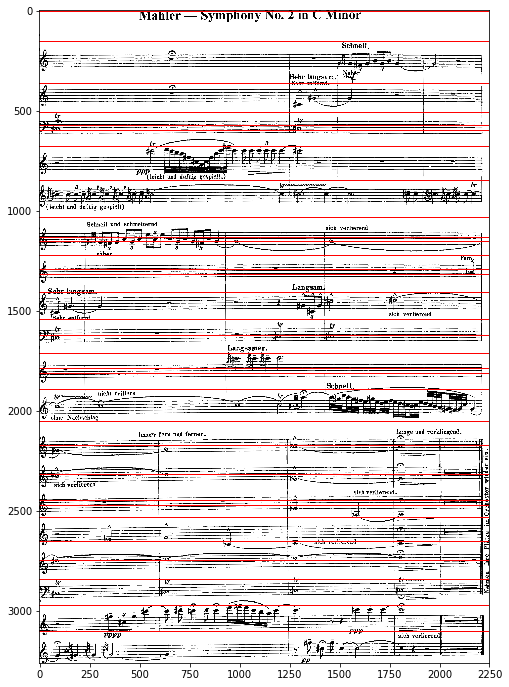

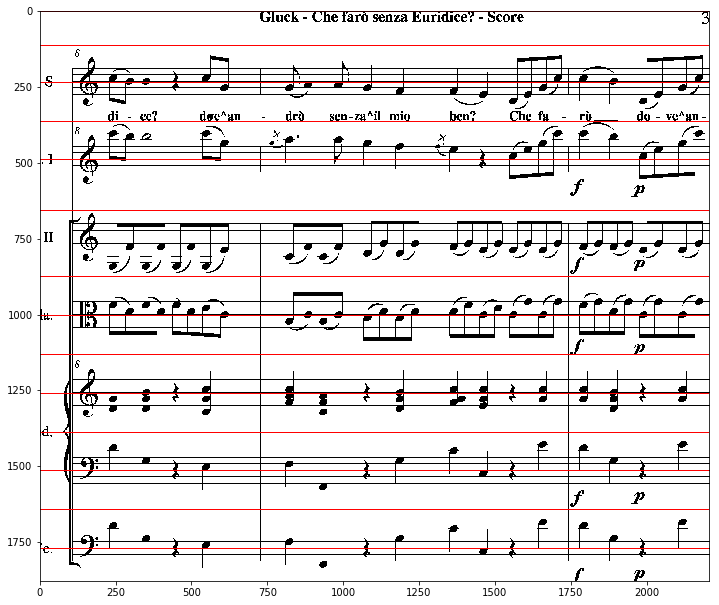

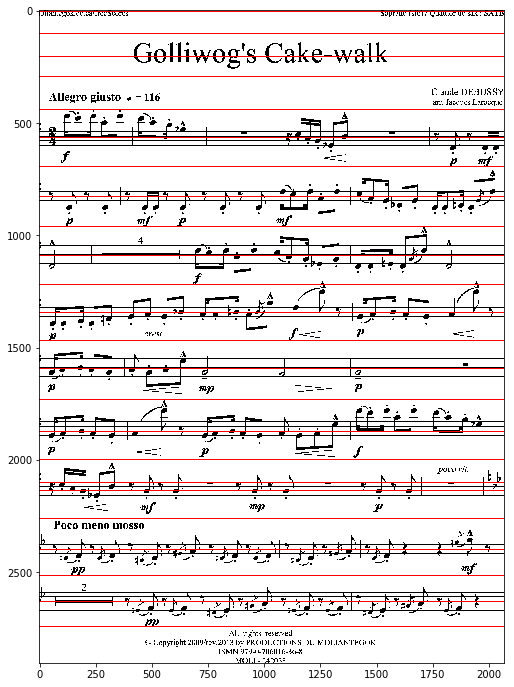

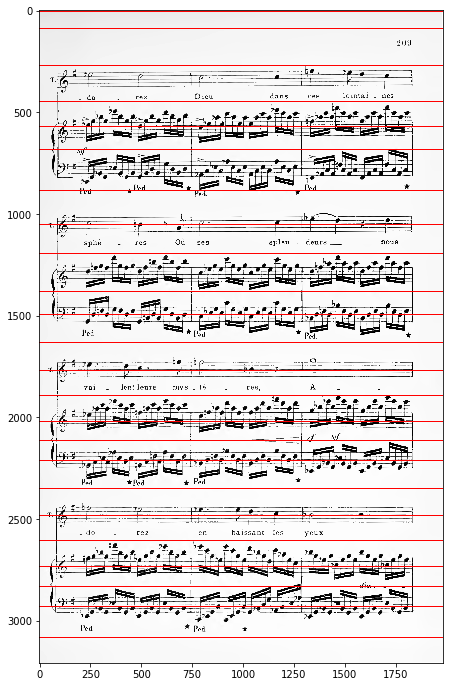

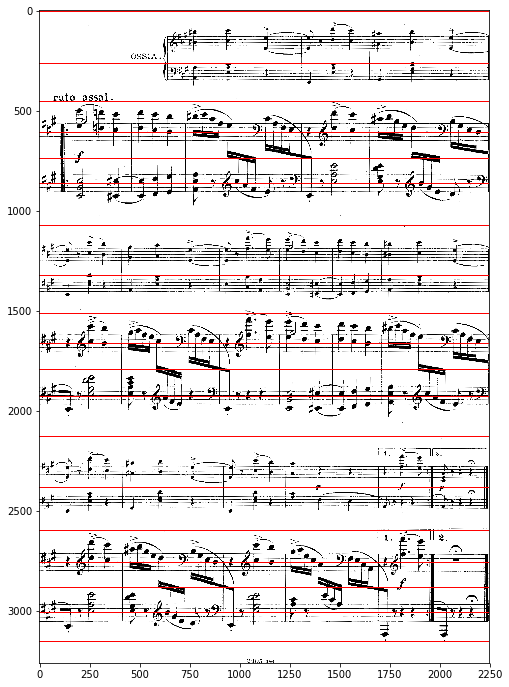

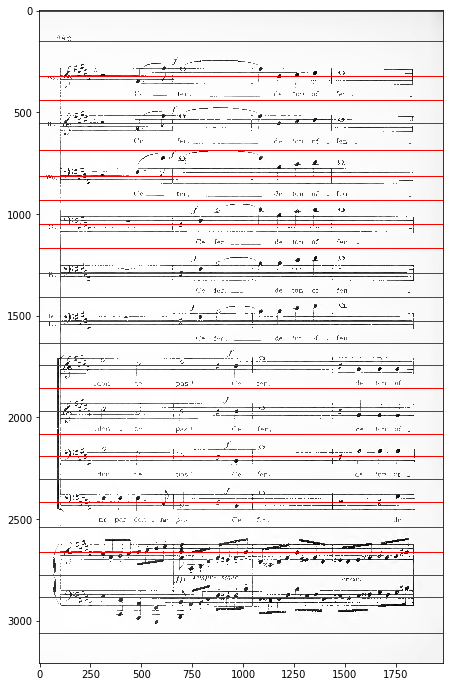

In [27]:
inspectBoundariesPre(pic_names[0:7],visualize_dir_pre)

In [28]:
def importBoundaryData(infile):
    d = {}  # key: basename, val: list of boundaries locations
    with open(infile,'r') as f:
        for line in f:
            parts = line.split()
            basename = parts.pop(0)
            bnds = map(int, parts)
            d[basename] = bnds
    return d

In [29]:
bndsfile = 'vis_bnds_test/bnds.predicted.txt'

In [30]:
bnds = importBoundaryData(bndsfile)

In [31]:
bnds

{'105172_page_142': <map at 0x7fe0893a6320>,
 '105172_page_69': <map at 0x7fe089408a90>,
 '221917_page_3': <map at 0x7fe0899a7898>,
 '248726_page_1': <map at 0x7fe089408438>,
 '309804_page_5': <map at 0x7fe0899ff320>,
 '43276_page_80': <map at 0x7fe0893fc198>,
 '55789_page_3': <map at 0x7fe089730588>}

In [32]:
bnds_1 = bnds['105172_page_142']

In [33]:
bnds_1

In [44]:
def viewBounds(filelist, bndsFile):
    d = importBoundaryData(bndsFile)
    for curfile in filelist:
        # get strip boundaries
        I = importImage(curfile)
        Irot, theta = rotateToHorizontal(I)
        ll, w, h = getBoundingBox(Irot)
        Icrop = getCropped(Irot)
        basename = os.path.splitext(os.path.basename(curfile))[0]
        bnds = d[basename]
        
        # generate images for inspection
        visualizeBoundaries(Icrop, bnds) # don't save

In [41]:
pic_names[0]

'pdf/mini_dataset_png/55789_page_3.png'

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  from ipykernel import kernelapp as app


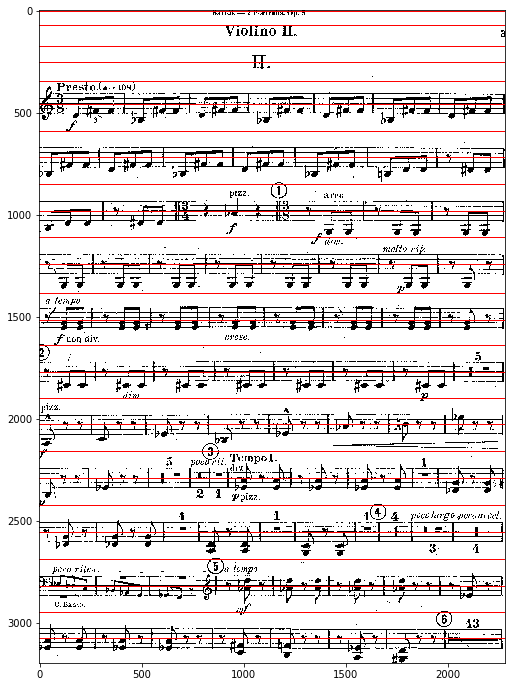

In [45]:
viewBounds([pic_names[0]], bndsfile)

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  from ipykernel import kernelapp as app
/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')


visualizing boundaries...


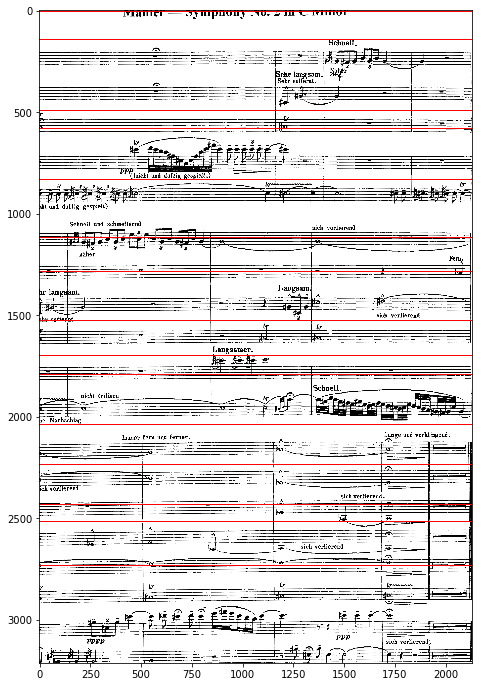

In [55]:
# try w piano ver
pic = pic_names[1]
I = importImage(pic)
Irot, theta = rotateToHorizontal(I)
Icrop = getCropped(Irot, thresh=0.2)
bnds_p = getStripBoundaries(Icrop)
print("visualizing boundaries...")
visualizeBoundaries(Icrop, bnds_p)

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  from ipykernel import kernelapp as app
/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')


visualizing boundaries...


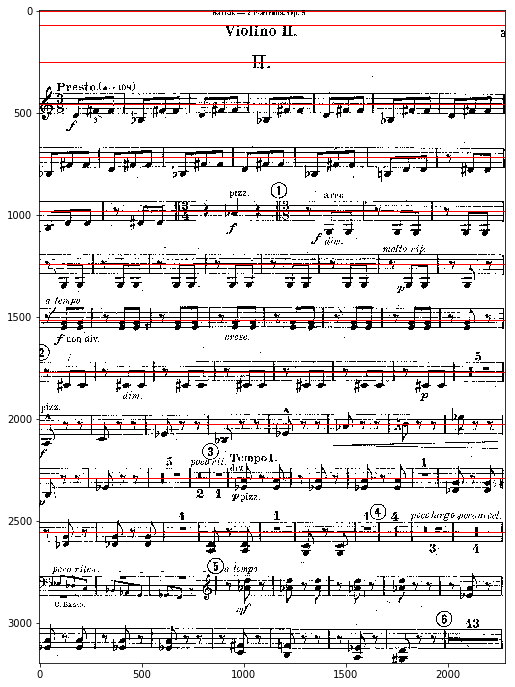

In [57]:
# try w piano ver
pic = pic_names[0]
I = importImage(pic)
Irot, theta = rotateToHorizontal(I)
Icrop = getCropped(Irot)
bnds_p = getStripBoundaries(Icrop)
print("visualizing boundaries...")
visualizeBoundaries(Icrop, bnds_p)

Idea: Do something w printing out # of peaks, etc. and decide # of red lines based off of that. Think about # of peaks and num bounds we SHOULD have.

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  from ipykernel import kernelapp as app


showing bounding box image...


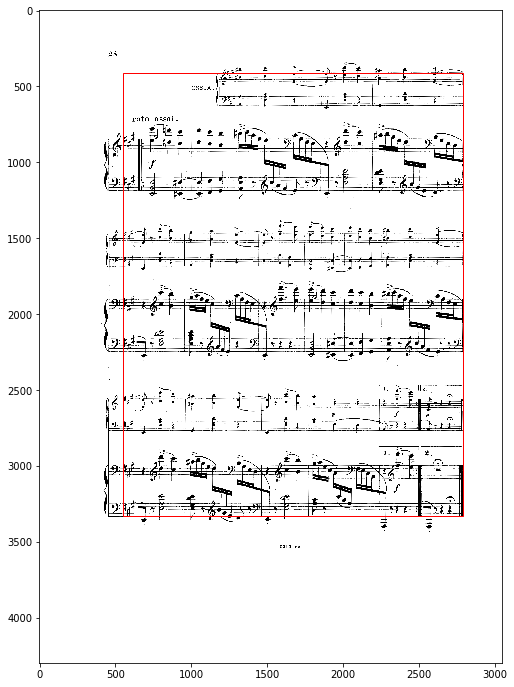

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')


X filter:
rsum is: [-4.49691144e+03  8.07048872e-13  8.07048872e-13 ... -3.90720870e+01
 -2.94939541e+02  3.46754537e+03]
rsum spectra: [[-4496.9116+0.0000000e+00j -4453.708 +0.0000000e+00j
  -4325.758 +0.0000000e+00j ...  3594.8452+0.0000000e+00j
   3623.9907+0.0000000e+00j  3594.8452+0.0000000e+00j]
 [ 4496.9116-2.0194839e-28j  4368.1313+8.6887531e+02j
   3996.4792+1.6553959e+03j ... -3142.452 +5.4493860e+02j
  -3221.1304-3.5527137e-15j -3142.452 -5.4493860e+02j]
 [-4496.9116-1.8144024e-28j -4114.6895-1.7043602e+03j
  -3058.7727-3.0587727e+03j ...  2545.4604-1.0464014e+03j
   2780.5603+2.8421709e-14j  2545.4604+1.0464014e+03j]
 ...
 [-4496.9116+1.0415793e-28j  4114.6895-1.7043602e+03j
  -3058.7727+3.0587727e+03j ... -3567.0046-1.4874469e+03j
   3902.4817+2.8421709e-14j -3567.0046+1.4874469e+03j]
 [ 4496.9116-2.0194839e-28j -4368.1313+8.6887531e+02j
   3996.4792-1.6553959e+03j ...  3767.6062+7.4488947e+02j
  -3878.1787+1.7763568e-14j  3767.6062-7.4488947e+02j]
 [-4496.9116+0.0000000e+

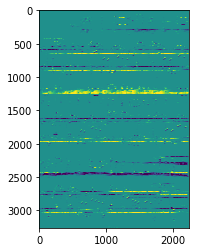

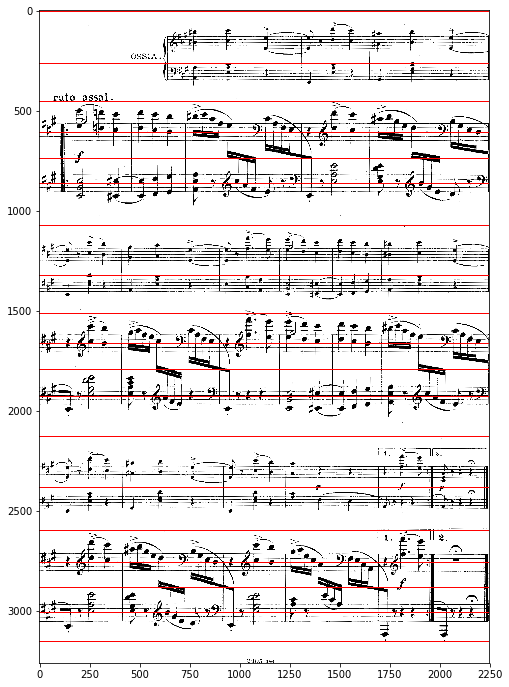

In [66]:
test_pic = pic_names[5]
I = importImage(test_pic)
Irot, theta = rotateToHorizontal(I)
ll, bbw, bbh = getBoundingBox(Irot, thresh=0.2)
print("showing bounding box image...")
showImageWithBB(Irot, ll, bbw, bbh)
Icrop = getCropped(Irot)
bnds = getStripBoundaries(Icrop, debug=True)
print("visualizing boundaries...")
visualizeBoundaries(Icrop, bnds)

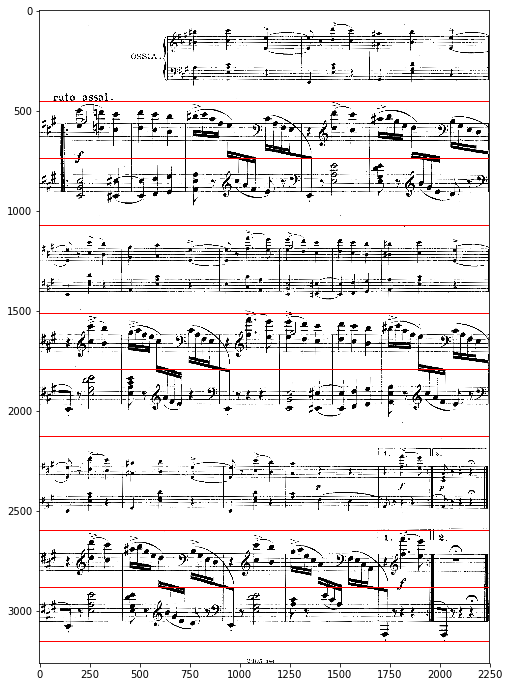

In [68]:
bnds_skip = bnds[2::2]
visualizeBoundaries(Icrop, bnds_skip)

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  from ipykernel import kernelapp as app


showing bounding box image...


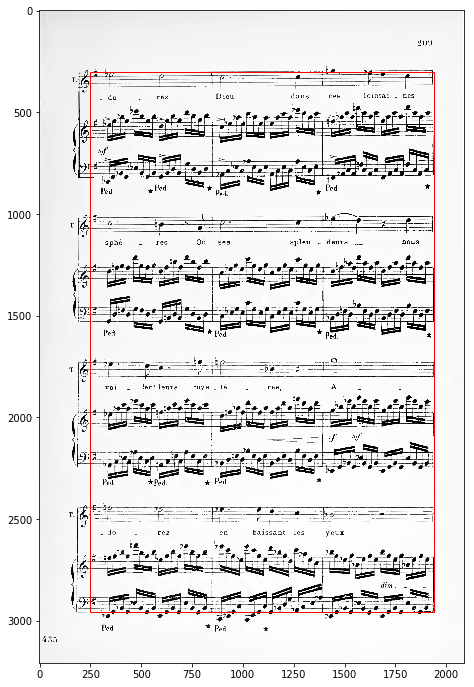

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')
/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


X filter:
rsum is: [-2977.16351629   909.4309843    977.43555667 ...  -146.10630869
  -170.31069556  4205.65789368]
rsum spectra: [[ 1880.6405 +0.0000000e+00j  1862.254  +0.0000000e+00j
   1807.812  +0.0000000e+00j ...  3451.5615 +0.0000000e+00j
   3485.2324 +0.0000000e+00j  3451.5615 +0.0000000e+00j]
 [-1563.3291 -2.9132252e-13j -1533.9386 -2.4200220e+02j
  -1448.1382 -4.6840613e+02j ... -3425.7012 +6.9004651e+02j
  -3528.6294 +3.5528872e-14j -3425.7012 -6.9004651e+02j]
 [  501.29724-2.2737368e-13j   514.9708 +5.6049591e+01j
    544.5802 +1.4153442e+02j ...  3337.4617 -1.3998052e+03j
   3654.3474 -1.4210855e-14j  3337.4617 +1.3998052e+03j]
 ...
 [-3734.2534 -2.2737368e-13j  3420.229  -1.4073027e+03j
  -2552.2273 +2.5281235e+03j ... -3987.925  -1.6513630e+03j
   4358.1914 -1.4210855e-14j -3987.925  +1.6513630e+03j]
 [ 3806.6245 -1.6342483e-13j -3698.7766 +7.3019373e+02j
   3387.466  -1.3916031e+03j ...  4238.169  +8.4252637e+02j
  -4363.012  +2.1314547e-14j  4238.169  -8.4252637e+02j]


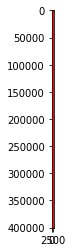

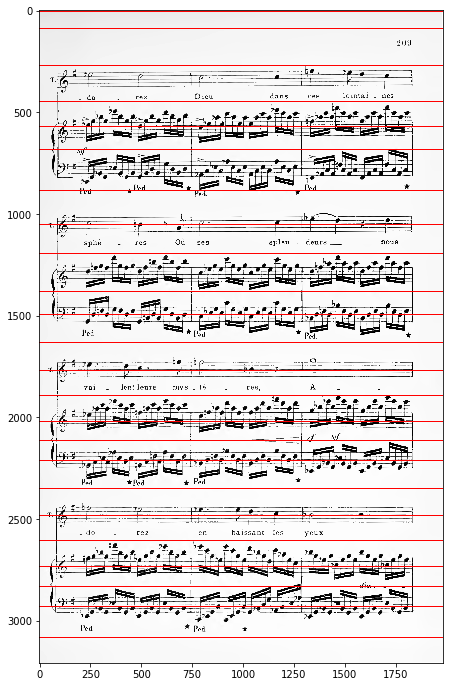

In [69]:
test_pic = pic_names[4]
I = importImage(test_pic)
Irot, theta = rotateToHorizontal(I)
ll, bbw, bbh = getBoundingBox(Irot, thresh=0.2)
print("showing bounding box image...")
showImageWithBB(Irot, ll, bbw, bbh)
Icrop = getCropped(Irot)
bnds = getStripBoundaries(Icrop, showPlot=True, debug=True)
print("visualizing boundaries...")
visualizeBoundaries(Icrop, bnds)

Let's maybe try to resize to (800,600) and see if that helps anything.

In [79]:
def importResizeImage(pngfile):
    img = ndimage.imread(pngfile, flatten=True)
    img = 1 - img/255.0 # make white -> 0, black -> 1
    img = resize_image(img, size=(800,600))
    return img

In [82]:
def resize_image(input_image, size):
    print(input_image.size)
    width, height = input_image.size
 
    resized_image = original_image.resize(size)
    return resized_image

In [ ]:
pic_test = pic_names[0]
I = importImage(pic_test)
Irot, theta = rotateToHorizontal(I)
ll, bbw, bbh = getBoundingBox(Irot, thresh=0.2)
print("showing bounding box image...")
showImageWithBB(Irot, ll, bbw, bbh)
Icrop = getCropped(Irot)
#Icrop_resized = np.resize(Icrop, (800,600))
bnds = getStripBoundaries(Icrop, showPlot=True, debug=True)
print("visualizing boundaries...")
visualizeBoundaries(Icrop, bnds)

/home/dbashir/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  from ipykernel import kernelapp as app
